#### Installing Dependencies

In [22]:
install.packages("tidyverse")
install.packages("xgboost")
install.packages("readr")
install.packages("corrplot")


The downloaded binary packages are in
	/var/folders/gc/yl9qvqzn2q58jx9w5td5w0c80000gn/T//Rtmpc6TeJb/downloaded_packages

The downloaded binary packages are in
	/var/folders/gc/yl9qvqzn2q58jx9w5td5w0c80000gn/T//Rtmpc6TeJb/downloaded_packages

The downloaded binary packages are in
	/var/folders/gc/yl9qvqzn2q58jx9w5td5w0c80000gn/T//Rtmpc6TeJb/downloaded_packages

The downloaded binary packages are in
	/var/folders/gc/yl9qvqzn2q58jx9w5td5w0c80000gn/T//Rtmpc6TeJb/downloaded_packages


#### Declaring Dependencies

In [27]:
library(corrplot)
library(tidyverse)
library(xgboost)
library(readr)
library(dplyr)
library(ggplot2)

#### Load Dataset

In [36]:
housing_data_train <- read_csv("House_Regression_Data/train.csv", show_col_types = FALSE)
housing_data_test <- read_csv("House_Regression_Data/test.csv", show_col_types = FALSE)

merge_data_set <- bind_rows(housing_data_train, housing_data_test, .id = "set")

head(merge_data_set, 5)

set,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,⋯,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,⋯,0,NA,NA,NA,0,5,2007,WD,Normal,181500
1,3,60,RL,68,11250,Pave,NA,IR1,Lvl,⋯,0,NA,NA,NA,0,9,2008,WD,Normal,223500
1,4,70,RL,60,9550,Pave,NA,IR1,Lvl,⋯,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
1,5,60,RL,84,14260,Pave,NA,IR1,Lvl,⋯,0,NA,NA,NA,0,12,2008,WD,Normal,250000


#### Preprocessing Of Data - Handling null values

In [46]:
double_values = sapply(merge_data_set, is.double)
text_values = sapply(merge_data_set, is.character)

In [48]:
# replacing NA values in numeric variables with the median of the respective column
merge_data_set[double_values] <- lapply(merge_data_set[double_values], function(column) {
  column[is.na(column)] <- median(column, na.rm = TRUE)
  return(column)
})

# converts all character variables into factors
merge_data_set[text_values] <- lapply(merge_data_set[text_values], function(column) as.factor(column))

In [50]:
processed_train <- merge_data_set %>% filter(set == "1") %>% select(-set)
processed_test <- merge_data_set %>% filter(set == "2") %>% select(-set, -SalePrice)

#### Data Analysis

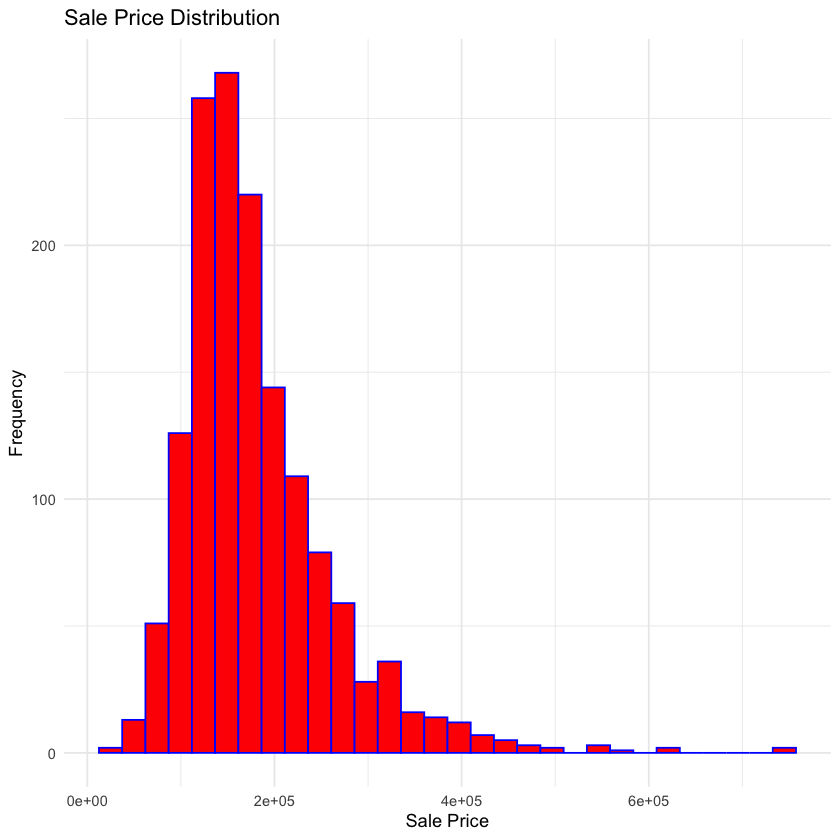

In [55]:
# Display histogram for sale price to get insight on price distribution
ggplot(processed_train, aes(SalePrice)) +
  geom_histogram(bins = 30, fill = "red", color = "blue") +
  theme_minimal() +
  labs(
    title = "Sale Price Distribution",
    x = "Sale Price",
    y = "Frequency"
  )

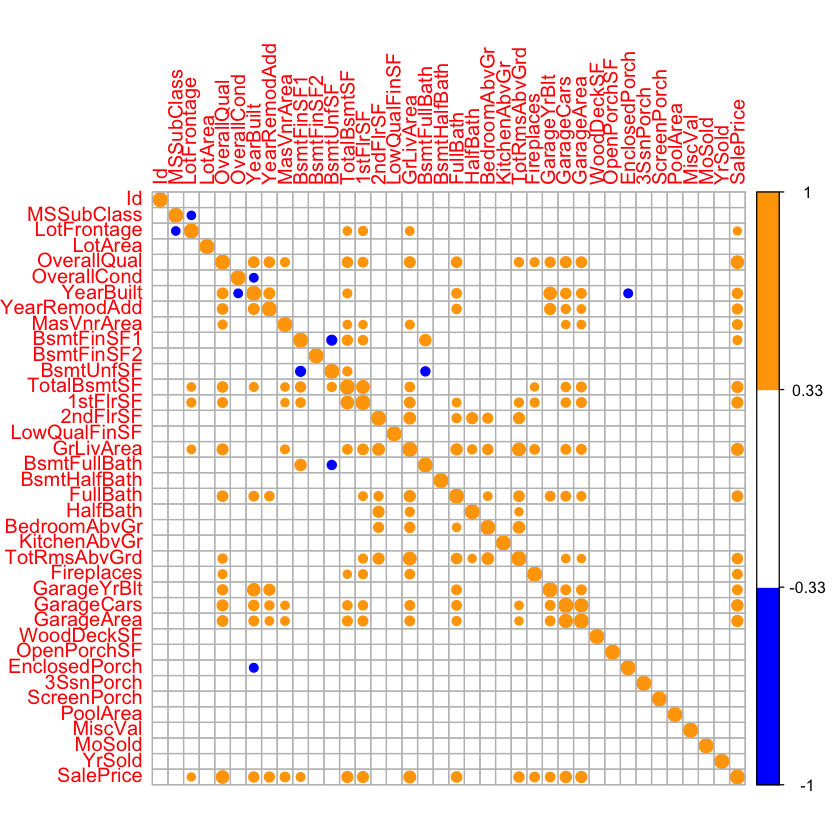

In [66]:
# correlation matrix to identify relationship bw variables
numeric <- processed_train %>% select(where(is.numeric))

matrix <- cor(numeric, use = "complete.obs")

color_palette <- c("blue", "white", "orange")

corrplot::corrplot(matrix, method = "circle", col = color_palette)

#### Feature Selection

In [79]:
high_corr_features <- names(matrix["SalePrice",][abs(matrix["SalePrice",]) > 0.5])

features_train <- processed_train[, high_corr_features]

features_train <- features_train %>% select(-SalePrice)

head(features_train, 5)

OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,2003,2003,856,856,1710,2,8,2,548
6,1976,1976,1262,1262,1262,2,6,2,460
7,2001,2002,920,920,1786,2,6,2,608
7,1915,1970,756,961,1717,1,7,3,642
8,2000,2000,1145,1145,2198,2,9,3,836


### Model Training - XGBOOST
#### XGBoost model is trained using the training data with specified parameters and an early stopping strategy.

#### Data Splitting

In [87]:
set.seed(123)
training_index <- sample(seq_len(nrow(features_train)), 0.8 * nrow(features_train))
housing_data_train <- features_train[training_index, , drop = FALSE]
housing_data_valid <- features_train[-training_index, , drop = FALSE]
target_train <- processed_train$SalePrice[training_index]
target_valid <- processed_train$SalePrice[-training_index]

train_final <- xgb.DMatrix(data = as.matrix(housing_data_train), label = target_train)
valid_final <- xgb.DMatrix(data = as.matrix(housing_data_valid), label = target_valid)

#### Model Training

In [97]:
params <- list(
  booster = "gbtree",
  objective = "reg:squarederror",
  eta = 0.1,
  max_depth = 6,
  min_child_weight = 1,
  subsample = 0.8,
  colsample_bytree = 0.8
)

# Train the model
xgb_model <- xgb.train(
  params = params,
  data = train_final,
  nrounds = 100,
  watchlist = list(train = train_final, valid = valid_final),
  early_stopping_rounds = 10,
  print_every_n = 10
)

[1]	train-rmse:178948.246292	valid-rmse:179912.037696 
Multiple eval metrics are present. Will use valid_rmse for early stopping.
Will train until valid_rmse hasn't improved in 10 rounds.

[11]	train-rmse:69245.951542	valid-rmse:74201.967507 
[21]	train-rmse:31730.488968	valid-rmse:40104.202573 
[31]	train-rmse:19803.662289	valid-rmse:31196.384815 
[41]	train-rmse:16024.407896	valid-rmse:29227.549287 
[51]	train-rmse:14574.487810	valid-rmse:28829.506047 
[61]	train-rmse:13495.550728	valid-rmse:28753.867818 
[71]	train-rmse:12588.076329	valid-rmse:28778.677946 
Stopping. Best iteration:
[66]	train-rmse:13078.979015	valid-rmse:28649.154381



#### Parameter Tuning

In [103]:
params <- list(
  booster = "gbtree",
  objective = "reg:squarederror",
  eta = 0.01,
  max_depth = 8,
  min_child_weight = 1,
  subsample = 0.7,
  colsample_bytree = 0.7,
  lambda = 1,
  alpha = 0.1
)

xgb_model <- xgb.train(
  params = params,
  data = train_final,
  nrounds = 1000,
  watchlist = list(train = train_final, valid = valid_final),
  early_stopping_rounds = 50,
  print_every_n = 10
)

[1]	train-rmse:195637.504657	valid-rmse:196163.684989 
Multiple eval metrics are present. Will use valid_rmse for early stopping.
Will train until valid_rmse hasn't improved in 50 rounds.

[11]	train-rmse:178114.246941	valid-rmse:178963.298802 
[21]	train-rmse:162186.928977	valid-rmse:163288.480349 
[31]	train-rmse:147768.588904	valid-rmse:149153.552555 
[41]	train-rmse:134736.076476	valid-rmse:136397.995812 
[51]	train-rmse:122880.337985	valid-rmse:124880.634731 
[61]	train-rmse:112209.000569	valid-rmse:114478.939181 
[71]	train-rmse:102531.462545	valid-rmse:105093.689587 
[81]	train-rmse:93803.852242	valid-rmse:96676.046215 
[91]	train-rmse:85916.629750	valid-rmse:89046.318455 
[101]	train-rmse:78759.646571	valid-rmse:82264.166488 
[111]	train-rmse:72251.838766	valid-rmse:76171.002613 
[121]	train-rmse:66367.088615	valid-rmse:70599.129267 
[131]	train-rmse:61076.961255	valid-rmse:65653.542961 
[141]	train-rmse:56284.226955	valid-rmse:61176.364050 
[151]	train-rmse:51983.924142	valid-

In [107]:
valid_preds <- predict(xgb_model, newdata = valid_final)

rmse <- sqrt(mean((valid_preds - target_valid)^2))
print(paste("Validation RMSE:", rmse))

[1] "Validation RMSE: 28928.0787548944"


#### Cross Validation - To improve model robustness

In [112]:
cv_results <- xgb.cv(
  params = params,
  data = train_final,
  nrounds = 500,
  nfold = 10,
  showsd = TRUE,
  stratified = FALSE,
  print_every_n = 10,
  early_stopping_rounds = 50,
  maximize = FALSE
)

best_nrounds <- cv_results$best_iteration
print(paste("Best number of rounds: ", best_nrounds))

[1]	train-rmse:195617.034178+1232.025522	test-rmse:195426.870496+10852.981924 
Multiple eval metrics are present. Will use test_rmse for early stopping.
Will train until test_rmse hasn't improved in 50 rounds.

[11]	train-rmse:178053.897638+1147.860120	test-rmse:178047.018644+10504.716228 
[21]	train-rmse:162166.374009+1064.890974	test-rmse:162317.633692+10251.975810 
[31]	train-rmse:147768.720270+996.556011	test-rmse:148104.631362+10022.477408 
[41]	train-rmse:134718.165301+937.881809	test-rmse:135254.999241+9773.989810 
[51]	train-rmse:122928.763996+853.802406	test-rmse:123719.978602+9560.524811 
[61]	train-rmse:112247.847264+798.348254	test-rmse:113269.275638+9330.364287 
[71]	train-rmse:102595.517363+740.042399	test-rmse:103857.523834+9108.167069 
[81]	train-rmse:93838.962574+682.986938	test-rmse:95397.194517+8897.661495 
[91]	train-rmse:85915.893698+620.640269	test-rmse:87736.342582+8728.962977 
[101]	train-rmse:78771.613155+558.961659	test-rmse:80972.649429+8542.566141 
[111]	tra

In [124]:
test_features <- processed_test[high_corr_features %>% setdiff("SalePrice")]
test_final <- xgb.DMatrix(data = as.matrix(test_features))

final_model <- xgb.train(
  params = params,
  data = xgb.DMatrix(data = as.matrix(features_train), label = processed_train$SalePrice),
  nrounds = best_nrounds
)

test_predictions <- predict(final_model, newdata = test_final)

output <- data.frame(Id = processed_test$Id, SalePrice = test_predictions)

write.csv(output, "house_regression_result.csv", row.names = FALSE)

head(output, 5)

,Id,SalePrice
,<dbl>,<dbl>
1,1461,124774.0
2,1462,145719.4
3,1463,163683.3
4,1464,180690.6
5,1465,202139.1
